# Classification Model for SketchRNN

In [1]:
!pip3 install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in ./venv/lib/python3.8/site-packages (3.1.0)


In [2]:
!nvidia-smi

Sun Jun 28 19:29:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce 920MX       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P0    N/A /  N/A |    185MiB /  2004MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [5]:
import os

In [6]:
quickdraw_dir = filepath[:-len(FILENAME)]
train_files = [(quickdraw_dir + f) for f in os.listdir(quickdraw_dir) if f.startswith('training.tfrecord-')]
eval_files = [(quickdraw_dir + f) for f in os.listdir(quickdraw_dir) if f.startswith('eval.tfrecord-')]

In [7]:
train_files

['/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010']

In [8]:
eval_files

['/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [9]:
with open(quickdraw_dir + 'training.tfrecord.classes') as training_classes_file:
    training_classes = training_classes_file.readlines()
    
with open(quickdraw_dir + 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()

In [10]:
assert training_classes == test_classes
class_names = [name.strip().lower() for name in training_classes]

In [11]:
print(sorted(class_names))

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [12]:
def parse(data_batch):
    feature_descrition = {
        'ink' : tf.io.VarLenFeature(dtype = tf.float32),
        'shape' : tf.io.FixedLenFeature([2], dtype = tf.int64),
        'class_index' : tf.io.FixedLenFeature([1], dtype = tf.int64)
    }
    
    examples = tf.io.parse_example(data_batch, feature_descrition)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1 , 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [13]:
def quickdraw_dataset(filepaths, batch_size = 32, shuffle_buffer_size = None,
                      n_parse_threads=2, n_read_threads=2, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls = n_parse_threads)
    return dataset.prefetch(1)

In [14]:
train_set = quickdraw_dataset(train_files,batch_size = 32,shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [15]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.11372549 -0.245       0.        ]
  [ 0.09803922 -0.16        0.        ]
  [ 0.11372548 -0.125       0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.00784314  0.5870647   0.        ]
  [ 0.01176471  0.17910445  1.        ]
  [ 0.1490196  -0.840796    0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.28440365  0.        ]
  [-0.05098039 -0.06422018  0.        ]
  [-0.0509804   0.03211009  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.02352941 -0.13063061  0.        ]
  [ 0.07450981 -0.11261262  0.        ]
  [ 0.05882353 -0.04054054  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [16]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

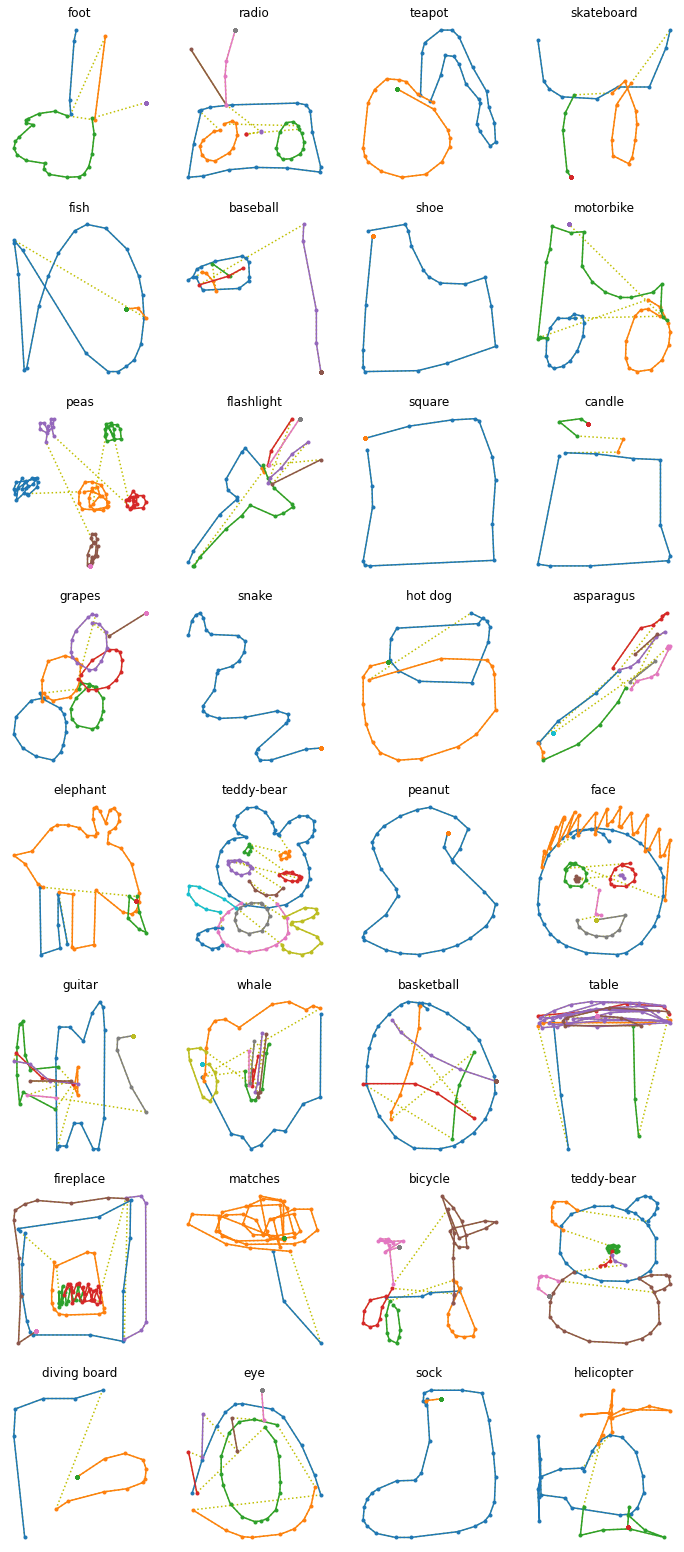

In [17]:
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch, label)
    plt.show()
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

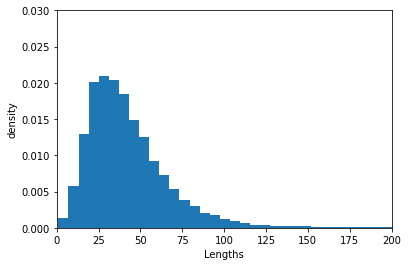

In [18]:
lengths = np.concatenate([lengths for _,lengths,_ in train_set.take(1000)])
plt.hist(lengths, bins=150, density = True)
plt.axis([0,200,0,0.03])
plt.xlabel('Lengths')
plt.ylabel('density')
plt.show()

In [19]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

In [20]:
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv1D(16, kernel_size= 5, strides=2, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(32, kernel_size= 5, strides=2, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size= 5, strides=2, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

In [24]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='nadam',
             metrics = ['accuracy','sparse_top_k_categorical_accuracy'])
history = model.fit(cropped_train_set, epochs = 2, validation_data=cropped_valid_set)

Epoch 1/2


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d_3/conv1d (defined at <ipython-input-24-c69d18a23f31>:3) ]] [Op:__inference_train_function_16848]

Function call stack:
train_function
